Завдання: Написати програму що реалізує згорткову нейронну мережу Inception V3 для розпізнавання об’єктів на зображеннях. Створити власний дата сет з папки на диску, навчити нейронну мережу на цьому датасеті розпізнавати породу Вашої улюбленої собаки чи кота. Навчену нейронну мережу зберегти на комп’ютер написати програму, що відкриває та аналізує зображення.

In [1]:
import tensorflow
from keras import Model
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPool2D, \
    Input, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, \
    Flatten, concatenate
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def conv_with_batch_normalisation (prev_layer, filters, filter_size, strides=(1,1), padding='same'):
    x = Conv2D (filters=filters, kernel_size=filter_size, strides=strides, padding=padding) (prev_layer)
    x = BatchNormalization (axis=3) (x)
    x = Activation(activation='relu') (x)
    return x

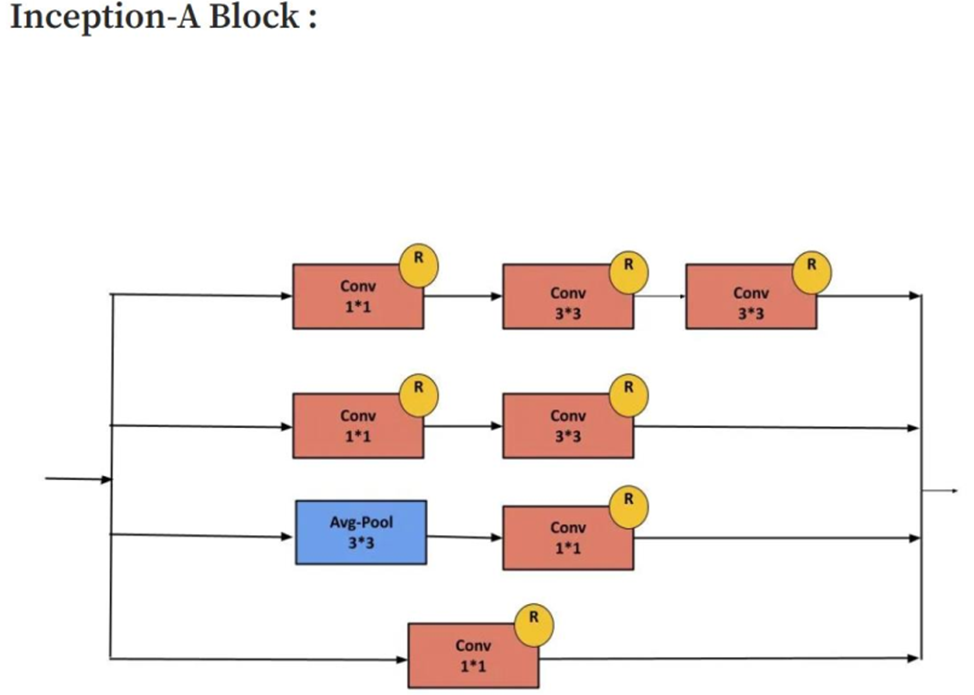

In [3]:
def inception_block_A(prev_layer, filters_branch3):
    #branch1 conv11 -> conv33 -> conv33 ->
    branch1 = conv_with_batch_normalisation(prev_layer, filters=64, filter_size=(1, 1)) 
    branch1 = conv_with_batch_normalisation(branch1, filters=96, filter_size=(3,3))
    branch1 = conv_with_batch_normalisation(branch1, filters=96, filter_size=(3,3))
    #branch2 conv11 -> conv33 ->
    branch2 = conv_with_batch_normalisation(prev_layer, filters=48, filter_size=(1, 1))
    branch2 = conv_with_batch_normalisation (branch2, filters=64, filter_size=(3, 3)) # may be 3*3
    #branch3 AvgPool33 -> conv11 ->
    branch3 = AveragePooling2D (pool_size=(3, 3), strides=(1, 1),    padding='same') (prev_layer)
    branch3 = conv_with_batch_normalisation(branch3, filters=filters_branch3, filter_size=(1, 1))
    # branch3 conv33 -> conv11 ->
    branch4 = conv_with_batch_normalisation(prev_layer, filters=64, filter_size=(1, 1))
    # branch4 conv11 -> 
    output = concatenate([branch1, branch2, branch3, branch4], axis=3) 
    return output

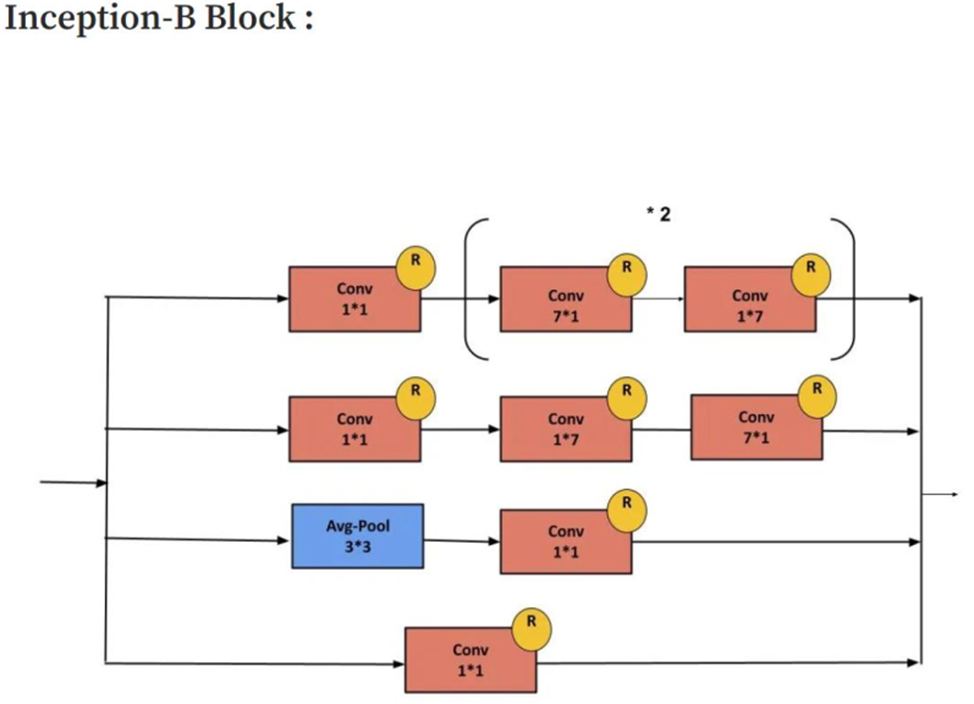

In [4]:
def inception_block_B(prev_layer, filters_br1_br2):
    branch1 = conv_with_batch_normalisation(prev_layer, filters=filters_br1_br2, filter_size=(1, 1))
    branch1 = conv_with_batch_normalisation(branch1, filters=filters_br1_br2, filter_size=(7, 1))
    branch1 = conv_with_batch_normalisation(branch1, filters=filters_br1_br2, filter_size=(1, 7))
    branch1 = conv_with_batch_normalisation(branch1, filters=filters_br1_br2, filter_size=(7, 1))
    ranch1 = conv_with_batch_normalisation(branch1, filters=192, filter_size=(1, 7))
    branch2 = conv_with_batch_normalisation(prev_layer, filters=filters_br1_br2, filter_size=(1, 1))
    branch2 = conv_with_batch_normalisation(branch2, filters=filters_br1_br2, filter_size=(1, 7))
    branch2 = conv_with_batch_normalisation(branch2, filters=192, filter_size=(7, 1))
    branch3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same') (prev_layer)
    branch3 = conv_with_batch_normalisation(branch3, filters=192, filter_size=(1, 1))
    branch4 = conv_with_batch_normalisation(prev_layer, filters=192, filter_size=(1, 1))
    output = concatenate([branch1, branch2, branch3, branch4], axis=3) 
    return output

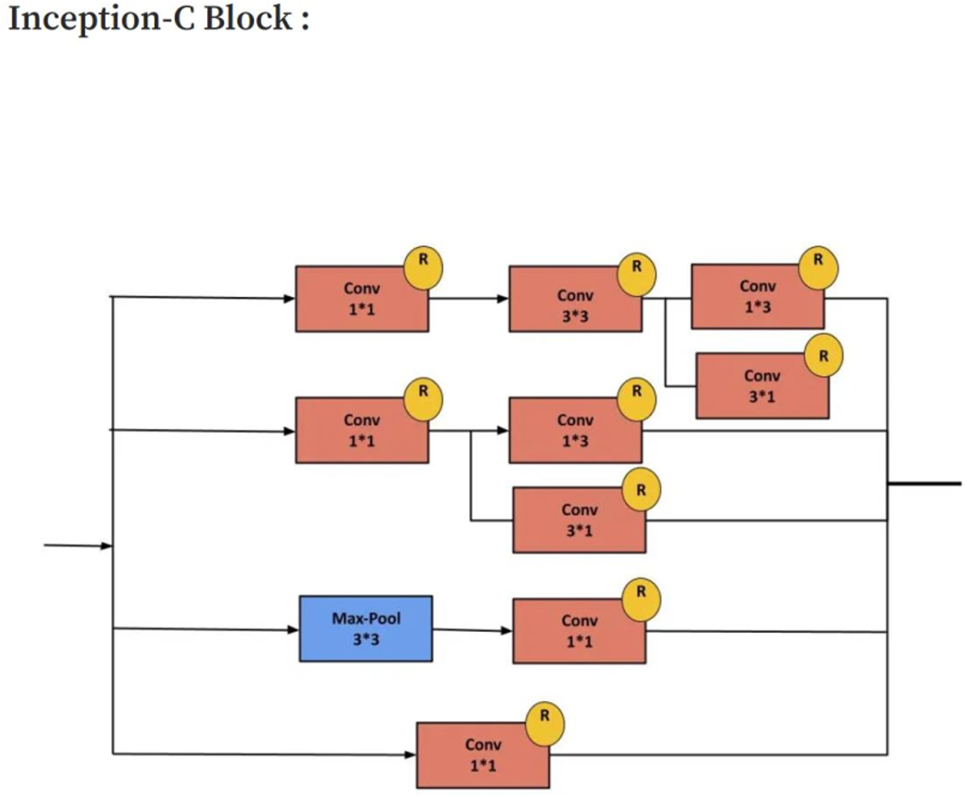

In [5]:
def inception_block_C (prev_layer):
    branch1 = conv_with_batch_normalisation(prev_layer, filters=448, filter_size=(1, 1))
    branch1 = conv_with_batch_normalisation(branch1, filters=384, filter_size=(3, 3))
    branch1_1 = conv_with_batch_normalisation(branch1, filters=384, filter_size=(1, 3))
    branch1_2 = conv_with_batch_normalisation(branch1, filters=384, filter_size=(3, 1))
    branch1 = concatenate([branch1_1, branch1_2], axis=3)
    branch2 = conv_with_batch_normalisation(prev_layer, filters=384, filter_size=(1, 1))
    branch2_1 = conv_with_batch_normalisation(branch2, filters=384, filter_size=(1, 3))
    branch2_2 = conv_with_batch_normalisation(branch2, filters=384, filter_size=(3, 1))
    branch2 = concatenate([branch2_1, branch2_2], axis=3)
    branch3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same') (prev_layer)
    branch3 = conv_with_batch_normalisation(branch3, filters=192, filter_size=(1, 1))
    branch4 = conv_with_batch_normalisation(prev_layer, filters=320, filter_size=(1, 1))
    output = concatenate([branch1, branch2, branch3, branch4], axis=3) 
    return output

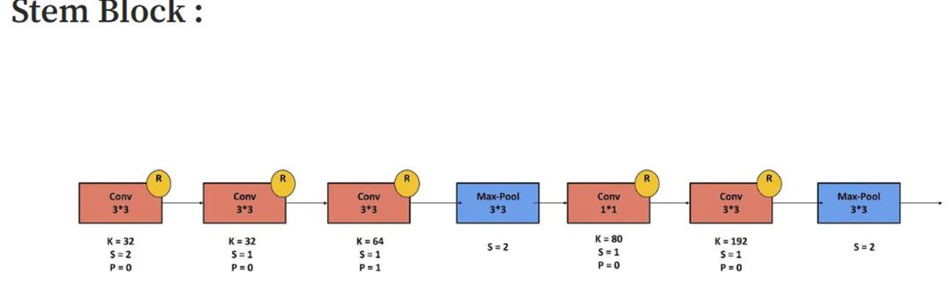

In [6]:
def stem_block (prev_layer):
    x = conv_with_batch_normalisation (prev_layer, filters=32, filter_size=(3, 3), strides=(2, 2))
    x = conv_with_batch_normalisation (x, filters=32, filter_size=(3, 3))
    x = conv_with_batch_normalisation(x, filters=64, filter_size=(3, 3))
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2)) (x)
    x = conv_with_batch_normalisation(x, filters=80, filter_size=(1, 1))
    x = conv_with_batch_normalisation(x, filters=192, filter_size=(3, 3)) 
    x = MaxPool2D (pool_size=(3, 3), strides=(2, 2)) (x)
    return x

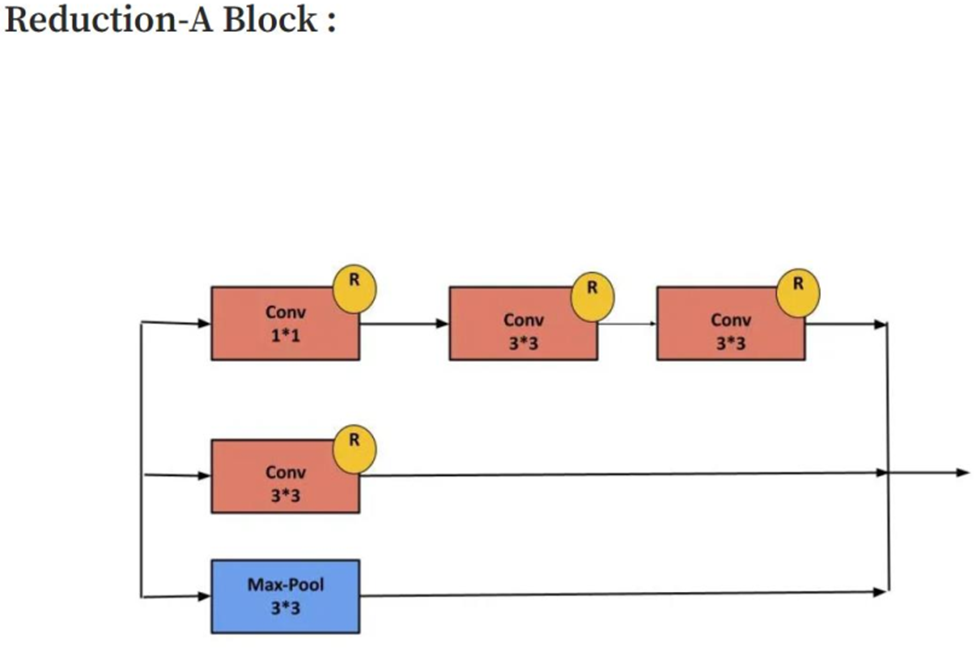

In [7]:
def reduction_block_A(prev_layer):
    branch1 = conv_with_batch_normalisation(prev_layer, filters=64, filter_size=(1, 1))
    branch1 = conv_with_batch_normalisation(branch1, filters=96, filter_size=(3,3))
    branch1 = conv_with_batch_normalisation(branch1, filters=96, filter_size=(3, 3), strides=(2, 2))
    branch2 = conv_with_batch_normalisation(prev_layer, filters=384, filter_size=(3, 3), strides=(2, 2))
    branch3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same') (prev_layer)
    output = concatenate([branch1, branch2, branch3], axis=3) 
    return output

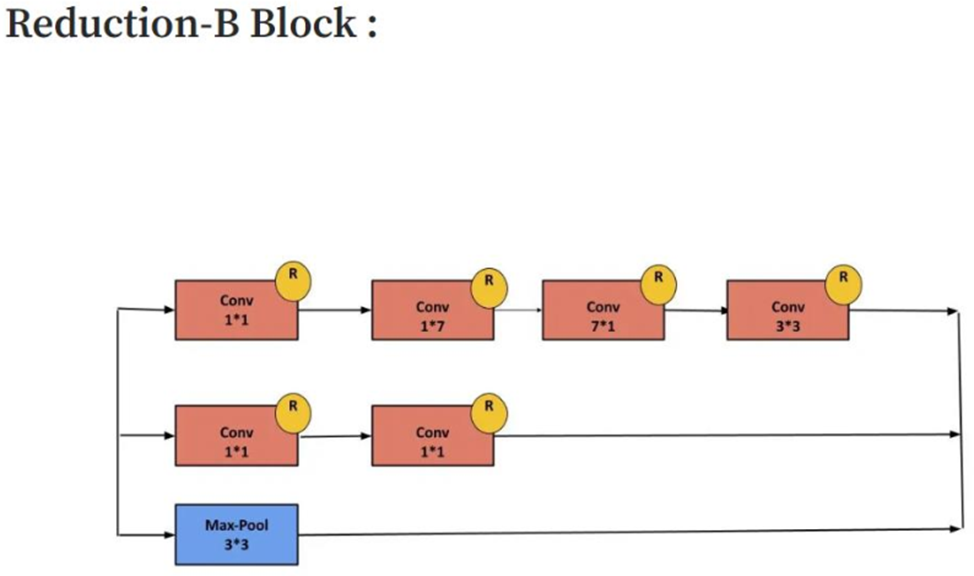

In [13]:
def reduction_block_B (prev_layer):
    branch1 = conv_with_batch_normalisation(prev_layer, filters=192, filter_size=(1, 1))
    branch1 = conv_with_batch_normalisation(branch1, filters=192, filter_size=(1, 7))
    branch1 = conv_with_batch_normalisation(branch1, filters=192, filter_size=(7, 1))
    branch1 = conv_with_batch_normalisation(branch1, filters=192, filter_size=(3, 3), strides=(2, 2), padding='valid')
    branch2 = conv_with_batch_normalisation(prev_layer, filters=192, filter_size=(1, 1))
    branch2 = conv_with_batch_normalisation(branch2, filters=320, filter_size=(3, 3), strides=(2, 2), padding='valid')
    branch3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2)) (prev_layer)
    output = concatenate ([branch1, branch2, branch3], axis=3) 
    return output

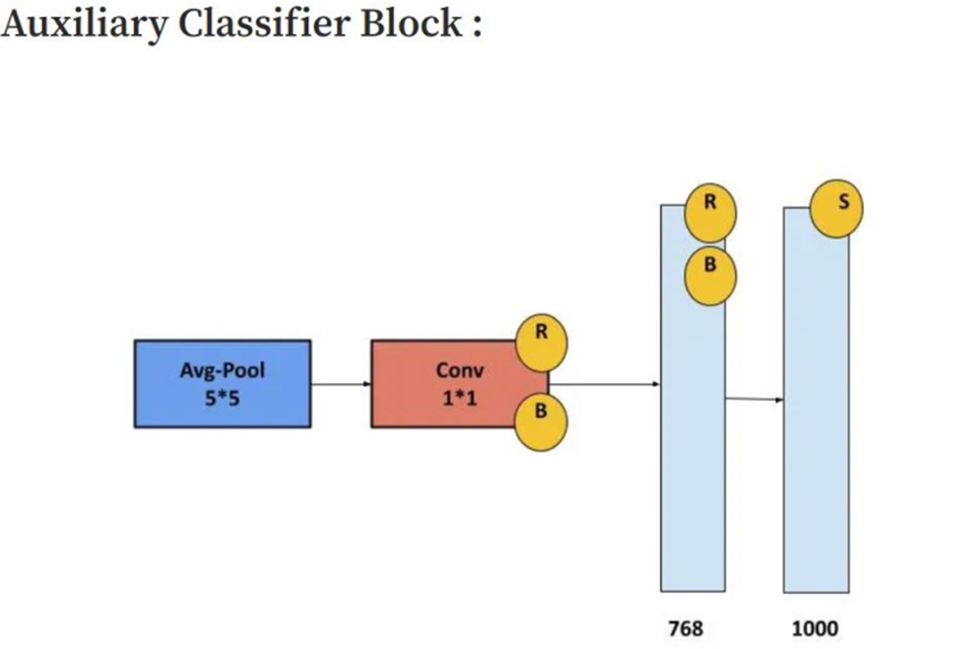

In [19]:
def auxiliary_classifier (prev_layer, output_size):
    x = AveragePooling2D(pool_size=(5, 5), strides=(3, 3)) (prev_layer)
    x = conv_with_batch_normalisation(x, filters=128, filter_size=(1, 1)) 
    x = Flatten () (x)
    x = Dense(units=768, activation='relu') (x)
    x = Dropout(rate=0.2) (x)
    x = Dense(output_size, activation='softmax', name='aux_output') (x) 
    return x

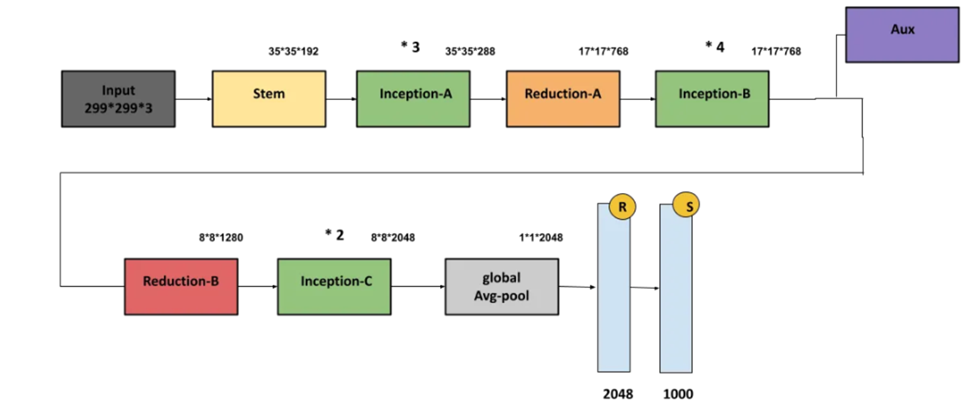

In [14]:
def InceptionV3(input_size, output_size): 
    input_layer = Input (shape=input_size)
    x = stem_block (input_layer)
    x = inception_block_A(x, filters_branch3=32) 
    x = inception_block_A(x, filters_branch3=64) 
    x = inception_block_A(x, filters_branch3=64)
    x = reduction_block_A(x)
    x = inception_block_B(x, filters_br1_br2=128) 
    x = inception_block_B(x, filters_br1_br2=160) 
    x = inception_block_B(x, filters_br1_br2=160) 
    x = inception_block_B(x, filters_br1_br2=192)
    Aux = auxiliary_classifier(x, output_size)
    x = reduction_block_B(x)
    x = inception_block_C(x)
    x = inception_block_C(x)
    x = GlobalAveragePooling2D () (x)
    x = Dense (2048, activation='relu') (x)
    x = Dropout (0.2) (x)
    x = Dense (output_size, activation='sigmoid', name='output') (x)
    model = Model (input_layer, [x, Aux])
    return model

по 1000 кожен клас

In [20]:
num_classes = 4  
model = InceptionV3((299, 299, 3), num_classes)


# training parameters
EPOCHS = 10
BATCH_SIZE = 32
image_height = 299
image_width = 299

# Шляхи до директорій для тренування та валідації для кожного класу
train_dir = "./breedsDataset/train"
valid_dir = "./breedsDataset/validation"

# Зазначення назв класів
class_names = ['birman', 'bombay', 'maine_coon', 'persian']


train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

# Зміна параметрів генераторів для відповідних кількостей класів
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    classes=class_names)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    classes=class_names)

train_num = train_generator.samples
valid_num = valid_generator.samples

Found 760 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [22]:

model.compile(optimizer= tensorflow.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [23]:
model.summary()
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_num // BATCH_SIZE,
                    verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_292 (Conv2D)         (None, 150, 150, 32)         896       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_292 (B  (None, 150, 150, 32)         128       ['conv2d_292[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_292 (Activation  (None, 150, 150, 32)         0         ['batch_normalization_292[

1/1 [==============================] - 0s 488ms/step
Prediction: [2 4 6 6]
True Label: 3
Prediction: [4 1 1 2]
True Label: 1


IndexError: index 2 is out of bounds for axis 0 with size 2

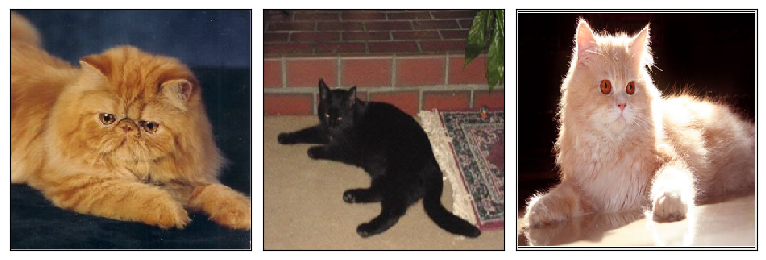

In [37]:
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


class_names = ['birman', 'bombay', 'maine_coon', 'persian']


x_valid, label_batch  = next(iter(valid_generator))
predict_x=model.predict(x_valid) 
prediction_values=np.argmax(predict_x,axis=1)

# set up the figure
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 227x227 pixels
for i in range(min(8, len(prediction_values))):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
  
    print("Prediction:", prediction_values[i])
    print("True Label:", np.argmax(label_batch[i]))
if prediction_values[i] == np.argmax(label_batch[i]):
    # label the image with the blue text
    ax.text(3, 17, class_names[prediction_values[i][0]], color='blue', fontsize=14)
else:
    # label the image with the red text
    ax.text(3, 17, class_names[prediction_values[i][0]], color='red', fontsize=14)
